<a href="https://colab.research.google.com/github/Omaam/deep-learning-from-scratch-5-with-jaxflax/blob/main/notebooks/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 変分オートエンコーダー（VAE）

ここでは jax/flax を用いて変分オートエンコーダー（VAE）を作成する。

## Imports

In [1]:
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np

import jax
from jax import numpy as jnp
from jax import random
import flax
from flax import linen as nn
from flax.training import train_state
import optax

## データ

ここでは`tensorflow.keras.datasets` を用いてダウンロードした MNIST を用いることにする。

In [2]:
from tensorflow.keras.datasets import mnist


(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape([-1, 784]).astype('float32') / 255
test_images = test_images.reshape([-1, 784]).astype('float32') / 255
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

train_images = train_images
test_images = test_images

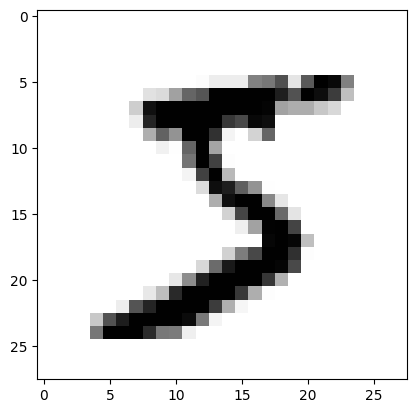

In [3]:
train_images_original = train_images.reshape(-1, 28, 28)

plt.imshow(train_images_original[0],
           vmin=0, vmax=1, cmap=plt.cm.gray_r)
plt.show()

## モデル

In [4]:
class Encoder(nn.Module):
    hidden_dim: int
    latent_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim, name='Dense1')(x)
        x = nn.relu(x)
        mu = nn.Dense(self.latent_dim, name='Dense_mu')(x)
        logvar = nn.Dense(self.latent_dim, name='Dense_logvar')(x)
        sigma = jnp.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    hidden_dim: int
    output_dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.hidden_dim, name='Dense1')(x)
        x = nn.relu(x)
        x = nn.Dense(self.output_dim, name='Dense2')(x)
        x = nn.sigmoid(x)
        return x


def reparameterize(mu, sigma):
    eps = np.random.randn(*sigma.shape)
    x = mu + eps * sigma
    return x


class VAE(nn.Module):
    hidden_dim: int = 200
    latent_dim: int = 20

    @nn.compact
    def __call__(self, x):
        input_shape = x.shape[-1]
        mu, sigma = Encoder(self.hidden_dim, self.latent_dim)(x)
        x = reparameterize(mu, sigma)
        x = Decoder(hidden_dim=self.hidden_dim, output_dim=input_shape)(x)
        return x

In [5]:
#@title Tests

x_dammy = train_images[0]
x_hat = VAE().apply(
    {'params': VAE().init(random.PRNGKey(0), x_dammy)['params']}, x_dammy
)
x_hat.shape

(784,)

## パラメータ推定

In [6]:
learning_rate = 3e-4

key, key1 = random.split(random.PRNGKey(0), 2)
variables = VAE().init(key1, train_images[0])

state = train_state.TrainState.create(
    apply_fn=VAE().apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=learning_rate)
)


def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.split(data[:num_batches*batch_size], num_batches)
    if mod:
        data_batched.append(data[num_batches*batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched


@jax.jit
def loss_fn(params, state, inputs, labels):
    predictions = state.apply_fn({'params': params}, inputs)
    loss = optax.l2_loss(predictions, inputs).mean()
    return loss


@jax.jit
def train_step(state, inputs, labels):
    '''パラメータの修正を１回だけ行う。
    '''
    loss, grads = jax.value_and_grad(loss_fn)(
        state.params, state, inputs, labels)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss


def train_epoch(state, input_batched, label_batched, eval=False):
    loss_history = []
    for inputs, labels in zip(input_batched, label_batched):
        # print(inputs.shape, labels.shape)
        new_state, loss = train_step(state, inputs, labels)
        loss_history.append(jax.device_get(loss).tolist())
    if eval:
        return state, np.mean(loss_history)
    else:
        return new_state, np.mean(loss_history)


def fit(state, train_inputs, train_labels, test_inputs, test_labels,
        epochs, batch_size):

    train_inputs_batched = create_batches(train_inputs, batch_size)
    train_labels_batched = create_batches(train_labels, batch_size)
    test_inputs_batched = create_batches(test_inputs, batch_size)
    test_labels_batched= create_batches(test_labels, batch_size)

    loss_history_train = []
    loss_history_test = []

    for epoch in range(1, epochs+1):

        # Training
        state, loss_train = train_epoch(
            state, train_inputs_batched, train_labels_batched
        )
        loss_history_train.append(loss_train)

        # Evaluation
        _, loss_test = train_epoch(
            state, test_inputs_batched, test_labels_batched, eval=True
        )
        loss_history_test.append(loss_test)

        print(
            'Epoch (Train): {}, Loss: {:.4f} | '.format(
                epoch, loss_train),
            end='', flush=True
        )
        print(
            'Epoch (Test): {}, Loss: {:.4f} | '.format(
                epoch, loss_test),
            flush=True
        )

    history = {'loss_train': loss_history_train,
               'loss_test': loss_history_test}

    return state, history

In [7]:
%%time
state, history = fit(state,
                     train_images, train_images,  # 入力と出力は同一
                     test_images, test_images,    # 入力と出力は同一
                     epochs=50,
                     batch_size=4096)

Epoch (Train): 1, Loss: 0.1316 | Epoch (Test): 1, Loss: 0.1288 | 
Epoch (Train): 2, Loss: 0.1287 | Epoch (Test): 2, Loss: 0.1261 | 
Epoch (Train): 3, Loss: 0.1260 | Epoch (Test): 3, Loss: 0.1236 | 
Epoch (Train): 4, Loss: 0.1235 | Epoch (Test): 4, Loss: 0.1211 | 
Epoch (Train): 5, Loss: 0.1211 | Epoch (Test): 5, Loss: 0.1189 | 
Epoch (Train): 6, Loss: 0.1188 | Epoch (Test): 6, Loss: 0.1167 | 
Epoch (Train): 7, Loss: 0.1166 | Epoch (Test): 7, Loss: 0.1146 | 
Epoch (Train): 8, Loss: 0.1145 | Epoch (Test): 8, Loss: 0.1125 | 
Epoch (Train): 9, Loss: 0.1124 | Epoch (Test): 9, Loss: 0.1106 | 
Epoch (Train): 10, Loss: 0.1105 | Epoch (Test): 10, Loss: 0.1086 | 
Epoch (Train): 11, Loss: 0.1085 | Epoch (Test): 11, Loss: 0.1066 | 
Epoch (Train): 12, Loss: 0.1065 | Epoch (Test): 12, Loss: 0.1047 | 
Epoch (Train): 13, Loss: 0.1046 | Epoch (Test): 13, Loss: 0.1027 | 
Epoch (Train): 14, Loss: 0.1026 | Epoch (Test): 14, Loss: 0.1007 | 
Epoch (Train): 15, Loss: 0.1006 | Epoch (Test): 15, Loss: 0.0987 |

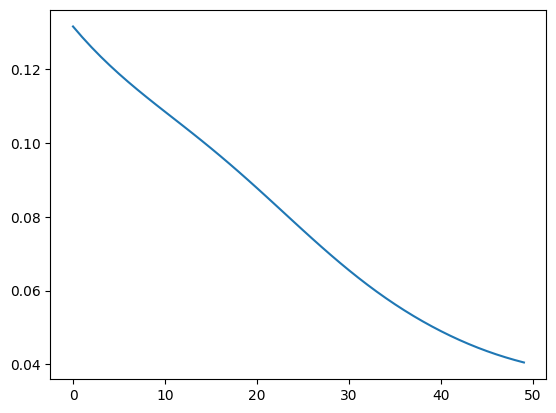

In [8]:
plt.plot(history['loss_train'])
plt.show()